In [1]:
import pandas as pd

In [2]:
raw_data = pd.read_csv('./students.csv')
raw_data

,Field of study,Last session debt,Other session debt,Attended classes %,Registred in VK conversations,Registred in moodle for all disciplins,Sportsman,Active in student activities,Teacher feedback,Continues studies
0,"""100503""",True,False,50-80,True,True,False,False,bad,True
1,"""090301""",True,False,< 30,True,True,False,True,good,True
2,"""100503""",False,False,> 80,False,True,True,False,good,True
3,"""100503""",True,False,< 30,False,False,False,False,ok,False
4,"""090301""",True,True,30-50,True,False,False,True,ok,False
...,...,...,...,...,...,...,...,...,...,...
495,"""090304""",False,True,30-50,True,False,False,True,ok,False
496,"""090304""",True,False,< 30,True,False,True,False,bad,False
497,"""090301""",True,False,< 30,True,True,True,False,bad,True
498,"""090304""",False,True,30-50,True,True,False,True,bad,True


# Препроцессинг

In [3]:
# Все заголовки
print( '\n'.join( raw_data.columns.to_list() ) )

Field of study
Last session debt
Other session debt
Attended classes %
Registred in VK conversations
Registred in moodle for all disciplins
Sportsman
Active in student activities
Teacher feedback
Continues studies


In [4]:
# Уникальные нечисловые значения
# Returns:
#     {column_name : {param : id, ...} | None , ... }
def get_uniq_non_numerical_values(df : pd.DataFrame) -> dict:
    unique_values = {}
    for colname in df.columns.to_list():
        # Проверяем тип
        if df[colname].dtype in ['int64', 'float']:
            unique_values[colname] = None #(False, [])
        else: 
            # Заносим в словарь
            d = {}
            # Генерируем маску на основе уникальных значений столбца
            for id_, param in enumerate(df[colname].unique().tolist()):
                d[param] = id_
            unique_values[colname] = d
            # Выводим только уникальные значения
            print(f"{colname}: {df[colname].unique().tolist()}")
    return unique_values

unique_colnames = get_uniq_non_numerical_values(raw_data)
print(50*'=')
# Там где значение уже числовое, вместо маски None
unique_colnames

Field of study: ['"100503"', '"090301"', '"090304"']
Last session debt: [True, False]
Other session debt: [False, True]
Attended classes %: ['50-80', '< 30', '> 80', '30-50']
Registred in VK conversations: [True, False]
Registred in moodle for all disciplins: [True, False]
Sportsman: [False, True]
Active in student activities: [False, True]
Teacher feedback: ['bad', 'good', 'ok']
Continues studies: [True, False]


{'Field of study': {'"100503"': 0, '"090301"': 1, '"090304"': 2},
 'Last session debt': {True: 0, False: 1},
 'Other session debt': {False: 0, True: 1},
 'Attended classes %': {'50-80': 0, '< 30': 1, '> 80': 2, '30-50': 3},
 'Registred in VK conversations': {True: 0, False: 1},
 'Registred in moodle for all disciplins': {True: 0, False: 1},
 'Sportsman': {False: 0, True: 1},
 'Active in student activities': {False: 0, True: 1},
 'Teacher feedback': {'bad': 0, 'good': 1, 'ok': 2},
 'Continues studies': {True: 0, False: 1}}

In [5]:
# Препроцессинг -- превращение в числовой массив на основе переданных масок
def preprocessing(df : pd.DataFrame, masks : dict[str, dict[str, int]]) -> pd.DataFrame:
    df_ = df.copy()

    for colname in masks:
        mask = masks[colname]
        if mask != None: df_[colname] = df[colname].map(mask)

    return df_

data = preprocessing(raw_data, unique_colnames)
data

,Field of study,Last session debt,Other session debt,Attended classes %,Registred in VK conversations,Registred in moodle for all disciplins,Sportsman,Active in student activities,Teacher feedback,Continues studies
0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,1,1,0
2,0,1,0,2,1,0,1,0,1,0
3,0,0,0,1,1,1,0,0,2,1
4,1,0,1,3,0,1,0,1,2,1
...,...,...,...,...,...,...,...,...,...,...
495,2,1,1,3,0,1,0,1,2,1
496,2,0,0,1,0,1,1,0,0,1
497,1,0,0,1,0,0,1,0,0,0
498,2,1,1,3,0,0,0,1,0,0


# Разделение данных

In [6]:
learning_part = 0.7
testing_part = 1 - learning_part
TARGET = 'Continues studies'

def split_df(df : pd.DataFrame, first_part : float, second_part : float) -> (pd.DataFrame, pd.DataFrame):
    df_1 = df.head(int(len(df) * first_part))
    df_2 = df.tail(int(len(df) * second_part)+1)
    return (df_1, df_2)

def get_learning_and_test(target:str, data:pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    zeros_data = data[data[TARGET] == 0]
    ones_data  = data[data[TARGET] == 1]
    learning_zeros_data, testing_zeros_data = split_df(zeros_data, learning_part, testing_part)
    learning_ones_data, testing_ones_data   = split_df(ones_data, learning_part, testing_part)
    
    learning_data = pd.concat([ learning_zeros_data, learning_ones_data ])
    learning_data.sample(frac=1)
    
    testing_data  = pd.concat([ testing_zeros_data,  testing_ones_data  ])
    testing_data.sample(frac=1)

    return learning_data, testing_data

learning_data, testing_data = get_learning_and_test(TARGET, data)
learning_params = learning_data.drop(TARGET, axis=1)
learning_labels = learning_data[TARGET]
testing_params = testing_data.drop(TARGET, axis=1)
testing_labels = testing_data[TARGET]

In [7]:
len(learning_data)

349

In [8]:
len(testing_data)

151

# Дерево принятия решений
> Построение по принципу ID3

## Энтропия (бинарная)
$$H(S)=-\sum_k^S{p_k\log_2{p_k}}$$

In [9]:
from math import log

In [10]:
# Энтропия -- мера неопределённости (непредсказуемости)
# labels -- набор меток
def entropy(labels : list):
    # считаем что log{0} = 0
    return sum(-p*log(p, 2) for p in labels if p>0)

# Прирост информации после разделения
# data -- DataFraim с данными
# split_attr -- признак для разделения
# target -- имя целевой переменной
def information_gain(data:pd.DataFrame, split_attr:str, target:str) -> float:
    # полная энтропия
    total_entropy = entropy(data[target])
    
    # все значения в колонке для разделения
    split_attr_values = data[split_attr].unique()
    # Энтропия после разделения
    after_split_entropy = 0
    for value in split_attr_values:
        # Выделяем подмножество для каждого класса значений
        sub_data = data[data[split_attr]==value]
        # Энтропия
        sub_data_entropy = entropy(sub_data[target])
        # коэффициент так как размер разный
        k = len(sub_data) / len(data)
        after_split_entropy += k*sub_data_entropy
    return total_entropy - after_split_entropy

# Находит лучший признак для разделения
# data -- DataFraim с данными
# attrs -- все признаки
# target -- имя целевой переменной
def find_best_split(data:pd.DataFrame, attrs:list[str], target:str) -> str:
    highest_gain = -1
    best_attr = None
    for attr in attrs:
        gain = information_gain(data, attr, target)
        if gain > highest_gain:
            highest_gain = gain
            best_attr = attr
            
    return best_attr # Если всё совсем плохо будет None

## Построение дерева

In [11]:
from collections import Counter

In [12]:
# Узел дерева 
# (гонять всё в виде словарей можно, но странно)
class TreeNode:
    attr : str
    branches : dict
    def __init__(self, attribute:str, branches={}):
        self.attr = attribute
        self.branches = branches

# Лист дерева (конечный узел)
class TreeLeaf:
    #class_
    count : int
    # Определяет метку по большинству
    def __init__(self, labels):
        popular = Counter(labels).most_common(1)
        self.class_ = popular[0][0]
        self.count = len(labels)

# 
def build_tree_ID3(data:pd.DataFrame, attrs:list[str], target:str, deph=0):
    labels = data[target]

    # Все labels одного класса
    if len(set(labels)) == 1: return TreeLeaf(labels)
    
    # Не осталось признаков
    if len(attrs) == 0: return TreeLeaf(labels)

    # Лучший признак для разделения
    split_attr = find_best_split(data, attrs, target)

    # Прирост информации нулевой
    if split_attr == None: return TreeLeaf(labels)

    # Узел решения
    tree = TreeNode(split_attr, {})

    # Создаём копию без использованного
    attrs_ = attrs.copy()
    attrs_.remove(split_attr)

    for value in data[split_attr].unique():
        # Подмножество
        sub_data = data[data[split_attr] == value]

        # Подмножество пустое
        if len(sub_data) == 0:
            tree.branches[value] = TreeLeaf(labels)
        # Иначе рекурсивно строим дерево
        else:
            tree.branches[value] = build_tree_ID3(sub_data, attrs_, target, deph+1)
    return tree

In [13]:
tree = build_tree_ID3(learning_data, learning_params.columns.to_list(), TARGET)

## Классификация (предсказание)

In [14]:
# Получает самый частый конечный элемент узла
def get_most_common(tree):
    # Если лист
    if isinstance(tree, TreeLeaf): return tree.class_
    # Собираем все метки
    classes = []
    for branch in tree.branches.values():
        # Если лист
        if isinstance(branch, TreeLeaf):
            for i in range(branch.count): classes.append(branch.class_)
        # Если ещё один узел, повторяем рекурсивно
        else: 
            classes.append(get_most_common(branch))
    # Самый частый
    return Counter(classes).most_common(1)[0][0]

# Рекурсивное получение предсказания для одного экземпляра
def predict_one(tree, sample : pd.Series):
    # Если лист, возвращаем ответ
    if isinstance(tree, TreeLeaf): return tree.class_
    # Иначе получаем значение, и идём рекурсивно
    attr_value = sample[tree.attr]
    # Если значения нет в дереве 
    # (например его не было в обучающей выборке, а в тестовой оказалось)
    if attr_value not in tree.branches:
        return get_most_common(tree)
    return predict_one(tree.branches[attr_value], sample)

# Предсказание для множества данных
def predict(tree, data:pd.DataFrame):
    # Делаем предсказание для каждой строки
    return [ predict_one(tree, row) for _, row in data.iterrows() ]

In [15]:
y_pred = predict(tree, testing_data)

In [16]:
y_true = testing_labels.to_list()

# Оценка метриками

In [17]:
# Для метрик
def get_statistic_for_metrics(predicted_y, testing_y):
    true_positive, true_negative = 0, 0
    false_positive, false_negative = 0, 0
    
    for y_pred, y_true in zip(predicted_y, testing_y):
        if y_pred == y_true == 1: true_positive += 1
        elif y_pred == y_true == 0: true_negative += 1
        elif y_pred != y_true and y_pred == 0: false_negative += 1
        elif y_pred != y_true and y_pred == 1: false_positive += 1
    return true_positive, true_negative, false_positive, false_negative

def precision(y_true, y_pred):
    TP, TN, FP, FN = get_statistic_for_metrics(y_pred, y_true)
    return TP / (TP + FP)

def recall(y_true, y_pred):
    TP, TN, FP, FN = get_statistic_for_metrics(y_pred, y_true)
    return TP / (TP + FN)

In [18]:
precision_ = precision(y_true, y_pred)
print(f'Precision: {precision_}')
recall_ = recall(y_true, y_pred)
print(f'Recall: {recall_}')

Precision: 0.6756756756756757
Recall: 0.49019607843137253


In [19]:
import matplotlib.pyplot as plt

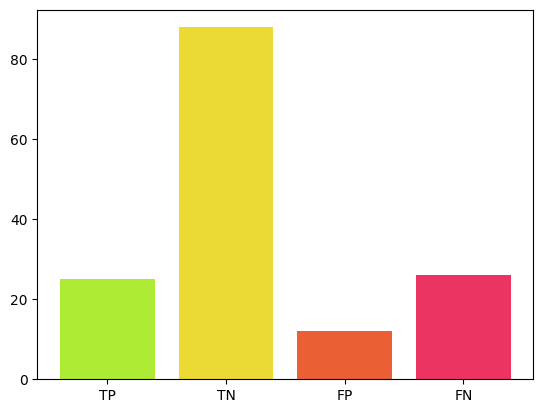

In [20]:
values = [ n for n in get_statistic_for_metrics(y_pred, y_true)]
colors = ['#aeeb34', '#ebd934', '#eb5f34', '#eb3462']
labels = ['TP', 'TN', 'FP', 'FN']

plt.bar(labels, values, color=colors)

plt.show()